<a href="https://colab.research.google.com/github/tpessoa-dev/plataformas-cognitivas/blob/main/ML_com_GCP_02_Criar_Dataset_Atividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autenticação
Primeiro precisamos autenticar nossa sessão do Colab no Google e definimos o ID do projeto

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


# Introdução

Neste processo, vamos gerar bases de Treinamento e de Teste utilizando as tarefas de processamento do Big Query de tal forma que o seguinte fluxo de dados será executado:

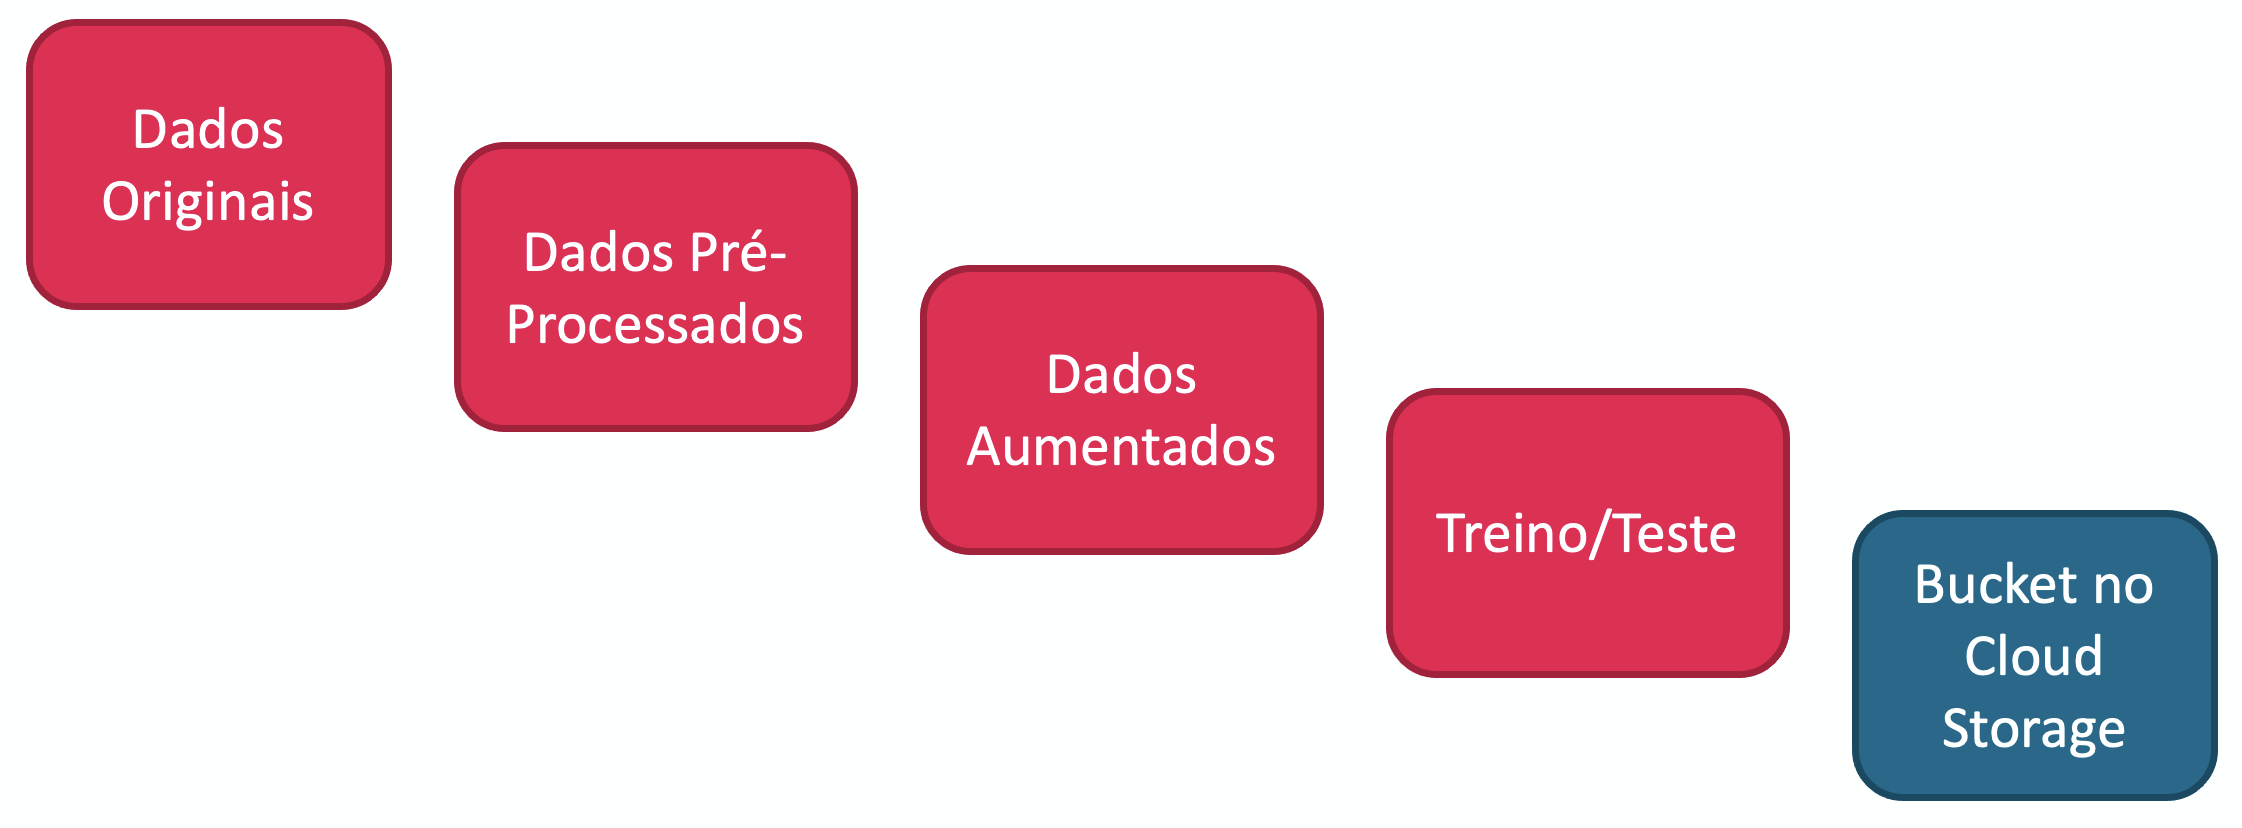

# Setup

Nesta seção vamos definir os parâmetros, criar local para armazenamento no BigQuery (datasets) e no Cloud Storage (Buckets e pastas).

## Bibliotecas / pacotes

In [ ]:
import os

from google.cloud import bigquery

## Parâmetros

In [ ]:
#@title Informe o id do projeto nesta linha e o bucket. Sugestão, coloque o nome do bucket como nome do projeto + um sufixo:
PROJECT = 'curso-gcp-ml-tensorflow' #@param {type:"string"}
BUCKET = 'curso-gcp-ml-tensorflow-17ia' #@param {type:"string"}

In [ ]:
#Outras variáveis:
REGION = 'us-central1'

#Variáveis do OS
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

In [ ]:
%%bash
echo "Your current GCP Project Name is: "$PROJECT

Your current GCP Project Name is: curso-gcp-ml-tensorflow


## Criação do conjunto de dados do BigQuery e um Bucket do Cloud Storage

Um conjunto de dados (dataset) do BigQuery é um contêiner para tabelas, views e modelos criados com o BigQuery ML. Vamos criar um chamado __pesobebes__. Também vamos criar um bucket no GCS para nosso projeto.

In [ ]:
%%bash

# Cria um BigQuery dataset
datasetexists=$(bq ls -d --project_id=$PROJECT | grep -w pesobebes)

if [ -n "$datasetexists" ]; then
    echo -e "BigQuery dataset já existe. Show, não vamos precisar criá-lo."

else
    echo "Criando BigQuery dataset chamado: pesobebes"
    
    bq --location=US mk --dataset \
        --description "Peso de Bebes para aula" \
        $PROJECT:pesobebes
fi
echo "Estes são os datasets do projeto:"
bq ls -d --project_id=$PROJECT    


Criando BigQuery dataset chamado: pesobebes
Dataset 'curso-gcp-ml-tensorflow:pesobebes' successfully created.
Estes são os datasets do projeto:
  datasetId   
 ------------ 
  babyweight  
  datasets    
  pesobebes   


In [ ]:
%%bash
## Cria um GCS bucket se não existir already...
exists=$(gsutil ls -d -p ${PROJECT}  | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket já existe. Show, não vamos precisar criá-lo."
    
else
    echo "Criando um novo GCS bucket."
    gsutil mb -l ${REGION} -p ${PROJECT} gs://${BUCKET}
fi
echo "Estes são os buckets do projeto:"
gsutil ls -p ${PROJECT}

Bucket já existe. Show, não vamos precisar criá-lo.
Estes são os buckets do projeto:
gs://17ia-preview/
gs://artifacts.curso-gcp-ml-tensorflow.appspot.com/
gs://curso-gcp-ml-tensorflow/
gs://curso-gcp-ml-tensorflow-17ia/
gs://curso-gcp-ml-tensorflow-beam/
gs://curso-gcp-ml-tensorflow-beam2/
gs://curso-gcp-ml-tensorflow-ds/
gs://curso-gcp-ml-tensorflow-mybucket/
gs://curso-gcp-ml-tensorflow-teste/
gs://curso-gcp-ml-tensorflow.appspot.com/
gs://curso-gcp-mltf-2021/
gs://staging.curso-gcp-ml-tensorflow.appspot.com/


# Processamento dos dados

Como já existe um dataset público, podemos simplesmente criar as tabelas de  treinamento e avaliação usando esses dados de entrada brutos.

Primeiro, vamos criar um subconjunto de dados limitando nossas colunas a `weight_kilos`,` is_male`, `mother_age`, `mother_married`, ` plurality` e `gestation_weeks`, bem como alguns filtros simples e uma coluna com hash para nos permitir reproduzir o processamento.

* Observação: o dataset "pesobebes" no código de criação da tabela abaixo é o criado anteriormente.

## Pré-processar e filtrar conjunto de dados

Temos alguns pré-processamento e filtragem que gostaríamos de fazer para colocar nossos dados no formato certo para o treinamento.

Pré-processamento:
* Cast `is_male` de` BOOL` para `STRING`
* Cast `pluralidade` de` INTEGER` para `STRING` onde` [1, 2, 3, 4, 5] `torna-se` ["1", "2", "3" , "4", "5"] `
* Adiciona hashing `hashcolumn` em` ano` e `mês`

Filtros:
* Só desejamos dados dos anos posteriores a `2000`
* Queremos apenas pesos do bebê maiores que `0`
* Queremos apenas mães com idade superior a `0`
* Só queremos que a pluralidade seja maior que `0`
* Queremos apenas que o número de semanas de gestação seja maior que `0`

In [ ]:
%%bigquery --project {PROJECT}
CREATE OR REPLACE TABLE
    pesobebes.pesobebes_preproc AS
SELECT
    weight_pounds * 0.45359237 AS weight_kilos,
    CASE
        WHEN is_male THEN 'True'
        ELSE 'False'
    END AS is_male,
    mother_age,
    CASE
        WHEN mother_married THEN 'True'
        ELSE 'False'
    END AS mother_married,
    CASE
        WHEN plurality = 1 THEN "1"
        WHEN plurality = 2 THEN "2"
        WHEN plurality = 3 THEN "3"
        WHEN plurality = 4 THEN "4"
        WHEN plurality = 5 THEN "5"
        WHEN plurality >= 6 THEN "6"
    END AS plurality,
    gestation_weeks,
    FARM_FINGERPRINT(
        CONCAT(
            COALESCE( CAST(year AS STRING), '' ),
            COALESCE( CAST(month AS STRING), '' ),
            COALESCE( CAST(day AS STRING), '' ),
            COALESCE( CAST(weight_pounds AS STRING), '' )
        )
    ) AS meuhash,
    RAND() AS meurand
FROM
    publicdata.samples.natality
WHERE
    year > 2000
    AND weight_pounds > 0
    AND mother_age > 0
    AND plurality > 0
    AND gestation_weeks > 0
    AND is_male IS NOT NULL
    AND mother_married IS NOT NULL

""


## Aumentar dataset para simular dados ausentes

Agora queremos aumentar nosso dataset com dados simulados de peso do bebê, definindo todas as informações de gênero como `Unknown` e definindo a pluralidade de todos os nascimentos não únicos como `Múltiplos (2+)`.

Para isso, usaremos a instrução UNION ALL do SQL:

```
SELECT
    weight_kilos,
    "Unknown" AS is_male,
    mother_age,
    mother_married,
    CASE
        WHEN plurality = "1" THEN plurality
        ELSE "2"
    END AS plurality,
    gestation_weeks,
    meuhash,
    meurand
FROM
    <<<qual tabela?>>>
```

In [ ]:
%%bigquery --project {PROJECT}
CREATE OR REPLACE TABLE
    pesobebes.pesobebes_aumentado AS
SELECT
    weight_kilos,
    is_male,
    mother_age,
    mother_married,
    plurality,
    gestation_weeks,
    meuhash,
    meurand
FROM
    pesobebes.pesobebes_preproc
UNION ALL
#<<<COLOQUE AQUI SEU CÓDIGO>>>

""


## Dividir em Treino e Teste.

Agora, usando a variável `meuhash` (ou `meurand`), divida os dados em duas tabelas:

- pesobebes.pesobebes_treino: contemplando 75% dos dados
- pesobebes.pesobebes_teste: contemplando o restante não utilizado no treino

Deixe na tabela resultante APENAS as colunas que serão usadas no modelo:


dica: `ABS(MOD(numero, 4)) < 3`

In [ ]:
%%bigquery --project {PROJECT}
CREATE OR REPLACE TABLE
    pesobebes.pesobebes_treino AS
SELECT
 <<<COLOQUE SEU CODIGO SQL AQUI>>>

""


In [ ]:
%%bigquery --project {PROJECT}
CREATE OR REPLACE TABLE
    pesobebes.pesobebes_teste AS
SELECT
 <<<COLOQUE SEU CODIGO SQL AQUI>>>

""


# Exportação do Bigquery para o GCS

In [ ]:
# Criamos um BigQuery client object.
client = bigquery.Client(project=PROJECT)

dataset_name = "pesobebes"

# Criamos um objeto de referência para o dataset
dataset_ref = client.dataset( dataset_id=dataset_name, project=client.project)

# Export ambas tabelas train and eval tables
for step in ["treino", "teste"]:
    destination_uri = os.path.join(
        "gs://", BUCKET, dataset_name, "data", "{}*.csv".format(step))
    table_name = "pesobebes_{}".format(step)
    table_ref = dataset_ref.table(table_name)
    extract_job = client.extract_table(
        table_ref,
        destination_uri,
        # Local do bucket deve ser o mesmo do dataset
        location="US",
    )  # API request
    extract_job.result()  # Espera a exportação acontecer.

    print("Exported {}:{}.{} to {}".format(
        client.project, dataset_name, table_name, destination_uri))

Exported curso-gcp-ml-tensorflow:pesobebes.pesobebes_treino to gs://curso-gcp-ml-tensorflow-17ia/pesobebes/data/treino*.csv
Exported curso-gcp-ml-tensorflow:pesobebes.pesobebes_teste to gs://curso-gcp-ml-tensorflow-17ia/pesobebes/data/teste*.csv


# Validação da exportação.

In [ ]:
%%bash
mkdir ./data
gsutil cp gs://${BUCKET}/pesobebes/data/*.csv ./data/

Copying gs://curso-gcp-ml-tensorflow-17ia/pesobebes/data/teste000000000000.csv...
Copying gs://curso-gcp-ml-tensorflow-17ia/pesobebes/data/treino000000000000.csv...
/ [2 files][  146.0 B/  146.0 B]                                                
Operation completed over 2 objects/146.0 B.                                      


In [ ]:
%%bash
wc -l ./data/*.csv
head ./data/*.csv
tail ./data/*.csv

  1 ./data/teste000000000000.csv
  1 ./data/treino000000000000.csv
  2 total
==> ./data/teste000000000000.csv <==
weight_kilos,is_male,mother_age,mother_married,plurality,gestation_weeks

==> ./data/treino000000000000.csv <==
weight_kilos,is_male,mother_age,mother_married,plurality,gestation_weeks
==> ./data/teste000000000000.csv <==
weight_kilos,is_male,mother_age,mother_married,plurality,gestation_weeks

==> ./data/treino000000000000.csv <==
weight_kilos,is_male,mother_age,mother_married,plurality,gestation_weeks
